In [4]:
cd git

C:\Users\aless\git


In [175]:

import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow import keras
from keras import layers # keras for tensorflow.keras   
import tensorflow_probability as tfp
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import pandas as pd
import os




# data parameters
dataset_name = "cifar10"
dataset_repetitions = 1
image_size_vqvae = 32
batch_size = 32
n_epochs = 30
_latent_dim = 3

# data loading


def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.resize(image, size=[image_size_vqvae, image_size_vqvae], antialias=True)
    return tf.clip_by_value(image / 255, 0.0, 1.0)


def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


# load dataset
x_train_scaled = prepare_dataset("train[:80%]+test[:80%]")
x_test_scaled = prepare_dataset("train[80%:]+test[80%:]")
#data_variance = np.var(x_train / 255.0) 
data_variance = 1 #random variance change it ???







class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices



def resblock(x, kernelsize, filters):
    fx = layers.Conv2D(filters, kernelsize, activation='relu', padding='same')(x)
    fx = layers.BatchNormalization()(fx)
    fx = layers.Conv2D(filters, kernelsize, padding='same')(fx)
    out = layers.Add()([x,fx])
    out = layers.ReLU()(out)
    out = layers.BatchNormalization()(out)
    return out


def get_encoder(latent_dim=3):
    encoder_inputs = keras.Input(shape=(image_size_vqvae, image_size_vqvae, 3))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = resblock(x, 3, 32)
    x = resblock(x, 3, 32)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = resblock(x, 3, 64)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=3):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 4, activation="relu", strides=2, padding="same")(latent_inputs) #dimesion of the filter 4x4 because in the decoding you jump a row each two and with 3x3 you evaluate only the zeros around your central pixel
    x = resblock(x, 4, 64)
    x = resblock(x, 4, 64)
    x = layers.Conv2DTranspose(32, 4, activation="relu", strides=2, padding="same")(x)
    x = resblock(x, 4, 32)
    x = resblock(x, 4, 32)
    decoder_outputs = layers.Conv2DTranspose(3, 4, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")




def get_vqvae(latent_dim=3, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(image_size_vqvae, image_size_vqvae, 3))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()




class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=3, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):#provare a fare un fit con un fit normale
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }




# CREATING THE VQ-VAE MODEL (vqvae_trainer)

# Creates and compiles of the model vq-vae
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=3, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())

# creates the saves destinations for model and weights
filename = './synthetic_data/checkpoints/vqvae_x_diffusion0.csv'
checkpoint_file = './synthetic_data/checkpoints/vqvae_x_diffusion'
load_checkpoint = './synthetic_data/checkpoints/vqvae_x_diffusion'
i = 1
while os.path.isfile(filename):
    filename = f'./synthetic_data/checkpoints/vqvae_x_diffusion{i}.csv'
    load_checkpoint = f'./synthetic_data/checkpoints/vqvae_x_diffusion{i-1}'
    checkpoint_file = f'./synthetic_data/checkpoints/vqvae_x_diffusion{i}'
    i += 1

# training of the neural network and then saves as a .csv file the model parameters hystory
'''params = vqvae_trainer.fit(x_train_scaled, epochs=n_epochs, batch_size=32)
model_params = pd.DataFrame(params.history)
model_params.to_csv(filename, index=False)# il file è pieno solo delle funzioni di loss ma non dei parametri del modella...???'''

# saves the weights of the training
#vqvae_trainer.save_weights(checkpoint_file)

# load the weights in checkpoint format
vqvae_trainer.load_weights(load_checkpoint)






Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_63 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 8, 8, 3)           131459    
                                                                 
 vector_quantizer (VectorQua  (None, 8, 8, 3)          192       
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         367075    
                                                                 
Total params: 498,726
Trainable params: 497,446
Non-trainable params: 1,280
_________________________________________________________________


1/1 [==============================] - 1s 542ms/step


1/1 [==============================] - 0s 185ms/step


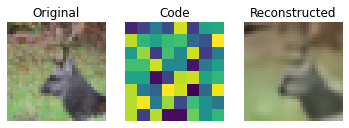

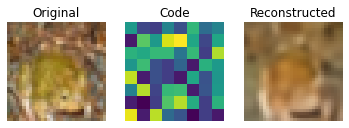

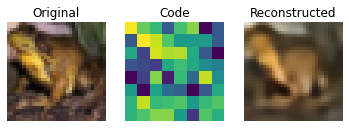

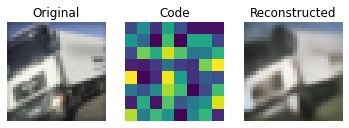

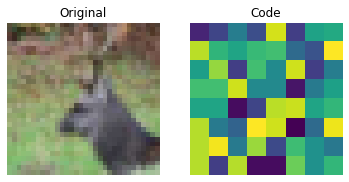

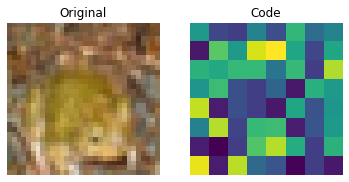

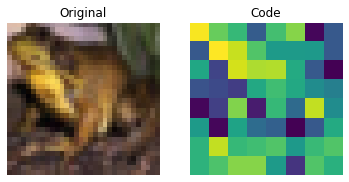

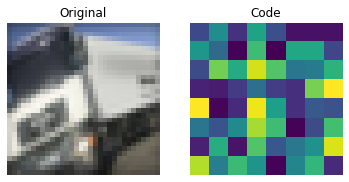

In [176]:
# show the images and the codes for numpy dataset for 4 images
def show_subplot(original, codebook_indices, reconstructed):
    plt.subplot(1, 3, 1)
    plt.imshow(original)# this for tensorflow dataset the following commented for numpy
    #plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(codebook_indices)
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed)# this for tensorflow dataset the following commented for numpy
    #plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

# with tensorflow dataset
for example in x_test_scaled.take(1):
  test_images = example[0:4]


trained_vqvae_model = vqvae_trainer.vqvae
'''
idx = np.random.choice(len(x_test_scaled), 4)
test_images = x_test_scaled[idx]
'''
reconstructions_test = trained_vqvae_model.predict(test_images)



encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for test_image,codebook_image, reconstructed_image in zip(test_images, codebook_indices, reconstructions_test):
    show_subplot(test_image, codebook_image, reconstructed_image)


for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i])# this for tensorflow dataset the following commented for numpy
    #plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

    

In [21]:



####################################################



# SETTING THE VQVAE OUTPUT AS DIFFUSION MODEL INPUT

encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")


# Take the training data, encodes and quantizes them
encoded_outputs = encoder.predict(x_train_scaled)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
training_codebook = quantizer.get_code_indices(flat_enc_outputs)

# Reshape the data in order to have shape for the diffusion (num_images, dim_code, dim_code)
training_codebook = training_codebook.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for the diffusion model: {training_codebook.shape}")

# The same with the validation data
encoded_outputs = encoder.predict(x_test_scaled)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
validation_codebook = quantizer.get_code_indices(flat_enc_outputs)

validation_codebook = validation_codebook.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the validation data for the diffusion model: {validation_codebook.shape}")



######################################################



1500/1500 [==============================] - 41s 27ms/step
Shape of the training data for the diffusion model: (48000, 8, 8)
375/375 [==============================] - 11s 27ms/step
Shape of the validation data for the diffusion model: (12000, 8, 8)


(-0.5, 7.5, 7.5, -0.5)

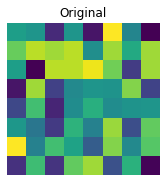

In [106]:
plt.subplot(1, 2, 1)
plt.imshow(training_codebook[1,:,:])# this for tensorflow dataset the following commented for numpy
#plt.imshow(test_images[i].squeeze() + 0.5)
plt.title("Original")
plt.axis("off")

In [22]:
training_codebook.shape


(48000, 8, 8)

In [178]:


# DIFFUSION ARCHITECTURE

# HYPERPARAMETERS

# data
dataset_repetitions = 1
num_epochs = 60  # train for at least 50 epochs for good results
image_size = 8
# KID = Kernel Inception Distance, see related section
kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64]
block_depth = 2

# optimization
batch_size = 32
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4
_latent_dim = 3



# set the training and validation data for the diffusion model
train_dataset = x_train_scaled
val_dataset = x_test_scaled




# KERNEL INCEPTION DISTANCE

class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size_vqvae, image_size_vqvae, _latent_dim)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, _latent_dim),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()




# NETWORK ARCHITECTURE

def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, _latent_dim))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")





# DIFFUSION MODEL

class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization() #DA AGGIUNGERE NEL VQVAE
        self.network = get_network(image_size, widths, block_depth)
        self.encoder = vqvae_trainer.vqvae.get_layer("encoder")
        self.quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")
        self.decoder = vqvae_trainer.vqvae.get_layer("decoder")
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, _latent_dim))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)

        # denormalized image -> decoded image
        generated_images = self.quantizer(generated_images, training=False)
        generated_images = self.decoder(generated_images, training=False)
        return initial_noise, generated_images

    def train_step(self, images):
        # encode the images from the vqvae model
        images = encoder(images, training=False)

        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, _latent_dim))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # quantize the images after diffusion
        pred_images = self.quantizer(pred_images, training=False)
        pred_images = self.decoder(pred_images, training=False)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # encode the images from the vqvae model
        images = encoder(images, training=False)

        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, _latent_dim))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)


        
        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        images = self.quantizer(images, training=False)
        images = self.decoder(images, training=False)

        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps
        )
        
        self.kid.update_state(images, generated_images)


        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # plot random generated images for visual evaluation of generation quality
        initial_noise, generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(initial_noise[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()



# CREATING THE DIFFUSION MODEL

# create and compile the model
model = DiffusionModel(image_size, widths, block_depth)
# below tensorflow 2.9:
# pip install tensorflow_addons
# import tensorflow_addons as tfa
# optimizer=tfa.optimizers.AdamW
model.compile(
    optimizer=keras.optimizers.experimental.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
# pixelwise mean absolute error is used as loss

# save the best model based on the validation KID metric
checkpoint_path = "./synthetic_data/checkpoints/diffusion_x_vqvae_hope"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

# INFERENCE

# load the best model and generate images
model.load_weights(checkpoint_path)
model.plot_images()


Epoch 1/60
  24/1500 [..............................] - ETA: 6:09 - n_loss: 0.6636 - i_loss: 1.8786

KeyboardInterrupt: 

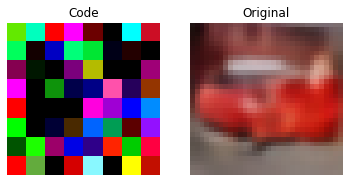

In [164]:
generated_images = model.generate(
            num_images=1,
            diffusion_steps=plot_diffusion_steps,
        )
initial_noise = tf.random.normal(shape=(image_size, image_size, _latent_dim))



plt.subplot(1, 2, 2)
plt.imshow(generated_images[0])# this for tensorflow dataset the following commented for numpy
#plt.imshow(test_images[i].squeeze() + 0.5)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 1)
plt.imshow(initial_noise)
plt.title("Code")
plt.axis("off")
plt.show()